In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def get_points_order(points):
    angles = np.arctan2(points[:, 0], points[:, 1])
    sorted_indices = np.argsort(angles)
    return sorted_indices

def masked_dynamics_step(particles, epsilon, beta, V):
    """
    Perform a single step of the masked dynamics.

    Args:
        particles (np.ndarray): The current state of the particles.
        epsilon (float): Step size.

    Returns:
        np.ndarray: The new state of the particles after the dynamics step.
    """
    interaction_matrix = np.dot(particles, particles.T) - 1  # Interaction matrix, -1 for stability
    interaction_matrix = np.tril(np.exp(beta * interaction_matrix))  # Lower triangular, exp-scaled
    interaction_matrix /= np.sum(interaction_matrix, axis=1, keepdims=True)  # Normalize rows
    delta = np.dot(interaction_matrix, np.dot(particles, V))  # Weighted sum of adjustments
    particles_new = particles + epsilon * delta  # Update positions
    return particles_new / np.linalg.norm(particles_new, axis=1, keepdims=True)  # Normalize


In [2]:
def get_groups(points, gap):
  # Groups of points indices such that corresponding point clouds are separated by gap from each other
  order = get_points_order(points)
  points_sorted = points[order]  # sorted points
  points_extended = np.concatenate((points_sorted, [points_sorted[0]]))
  diffs = np.diff(points_extended, axis=0)
  distances = np.linalg.norm(diffs, axis=1)
  gaps = np.where(distances > gap)[0]
  groups = np.split(order, (gaps+1).tolist())
  groups[0] = np.concatenate((groups[0], groups[-1])) # Those are the same group because we are on a circle
  groups.pop()
  leaders = []
  for group in groups:
    leaders.append(np.min(group))
  return groups, leaders

def parking(X, d):
  # Store ids of Renyi parking clusters
  current = [0]
  for id, el in enumerate(X):
    if np.min(np.linalg.norm(el - X[np.array(current)], axis = 1))>2*np.sin(d/2):
      current.append(id)
  return np.array(current)

def overlapped_parking(X, d):
  # Store ids of tokens that are from from all previous ones
  current = [0]
  for id, el in enumerate(X):
    if id==0:
      continue
    if np.min(np.linalg.norm(el - X[:id], axis = 1))> 2*np.sin(d/2):
      current.append(id)
  return np.array(current)

In [3]:
# Here let's try to figure out not moving clusters first! And find out what the distance should be.
# To this aim we think that the time is big enough for points to stabilize.

def run_dynamics(beta, T = 10000, dimension = 2, n_particles = 256, epsilon = 0.05):
  X = np.random.normal(0, 1, size=(n_particles, dimension))
  X /= np.linalg.norm(X, axis=1, keepdims=True)  # Normalize
  V = np.eye(dimension)  # Identity matrix for dimension 2
  data = [X.copy()]
  for i in tqdm(range(T)):
      X = masked_dynamics_step(X, epsilon, beta, V)
      data.append(X.copy())
  data = np.array(data)
  groups_halftime, leaders_halftime = get_groups(data[T//2], 0.07)
  groups_end, leaders_end = get_groups(data[T-1], 0.07)
  max_separation = 1
  min_separation = 0
  for leader in leaders_end:
    if leader!=0:
      max_separation = min(max_separation, np.min(np.linalg.norm(data[0][leader] - data[0][:leader], axis = 1)))
  for i in range(50):
    if i not in leaders_end:
      min_separation = max(min_separation, np.min(np.linalg.norm(data[0][i] - data[0][:i], axis = 1)))

  return 2*np.arcsin(min_separation/2), 2*np.arcsin(max_separation/2), leaders_end, data



In [1]:
ans = []
for _ in range(200):
  x, y, leaders, data = run_dynamics(beta = 49)
  ans.append((x, y))
  print(f"{x:.2f}, {y:.2f}")



NameError: name 'run_dynamics' is not defined

In [6]:
x*7, y*7, leaders

(4.371693749316329, 3.7441895675326275, [3, 22, 6, 16, 1, 0])

In [11]:
groups, leaders = get_groups(data[9999], 0.07)
for group in groups:
  print(np.sort(group))

[  3   4  14  18  32  34  35  41  42  44  47  49  52  60  84  88  92 103
 119 134 135 158 162 168 169 171 172 187 194 196 203 204 205 235 239 246
 250]
[ 22  46  67  69  75  86  99 110 115 126 127 130 141 157 159 167 178 192
 195 230]
[  6  15  25  38  40  56  57  61  62  63  65  73  77  81  97 100 107 117
 121 122 124 129 136 138 143 148 150 155 160 164 165 173 177 182 191 198
 202 207 208 211 219 222 223 228 244 249 255]
[ 16  17  19  24  26  29  33  39  54  64  80  82  90 101 104 106 111 113
 116 120 123 125 133 137 142 144 146 152 153 154 156 181 184 200 206 210
 217 218 227 236 237 241 243 252 253]
[  1   2  11  30  48  51  55  68  74  76  83  89  93  94  95 102 105 112
 131 151 174 179 188 190 212 215 221 224 231 254]
[  0   5   7   8   9  10  12  13  20  21  23  27  28  31  36  37  43  45
  50  53  58  59  66  70  71  72  78  79  85  87  91  96  98 108 109 114
 118 128 132 139 140 145 147 149 161 163 166 170 175 176 180 183 185 186
 189 193 197 199 201 209 213 214 216 220 225 22

In [12]:
overlapped_parking(data[0], 4/np.sqrt(49))

array([ 0,  1,  3,  6,  9, 16])

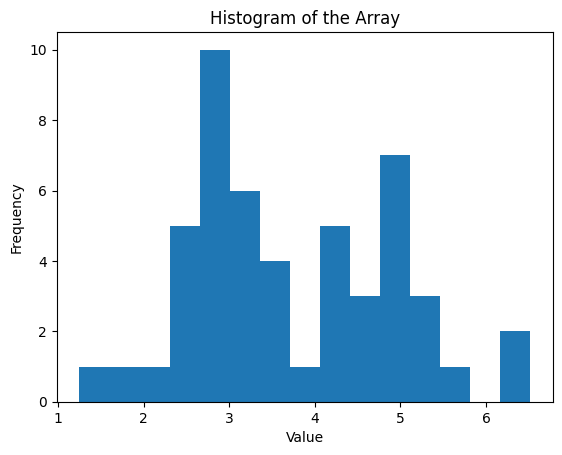

In [24]:
import numpy as np
import matplotlib.pyplot as plt


# Calculate the minimum and maximum values of the array for the range
min_val, max_val = np.min(ans), np.max(ans)

# Plotting the histogram
plt.hist(ans, bins=15, range=(min_val, max_val))
plt.title('Histogram of the Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [ ]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np

# Function to be executed in parallel
def run_task(_):
    return run_dynamics(49)

# Number of tasks to run in parallel
n_tasks = 100

# Use ProcessPoolExecutor to parallelize the task
with ProcessPoolExecutor() as executor:
    results = list(executor.map(run_task, range(n_tasks)))

# Convert results to a numpy array
ans = np.array(results)




100%|██████████| 10000/10000 [00:16<00:00, 615.95it/s]


0.6128247385854731

In [ ]:
def experiment(T, beta, c, dimension = 2, n_particles = 256, epsilon = 0.02):
  X = np.random.normal(0, 1, size=(n_particles, dimension))
  X /= np.linalg.norm(X, axis=1, keepdims=True)  # Normalize
  V = np.eye(dimension)  # Identity matrix for dimension 2
  data = [X.copy()]
  metaclusters = parking(data[0], d = c/np.sqrt(beta))
  clusters = overlapped_parking(data[0], d = c/np.sqrt(beta))
  for i in tqdm(range(T)):
      X = masked_dynamics_step(X, epsilon)
      data.append(X.copy())
      if i%50 == 0:
        pass

  data = np.array(data)


In [14]:
clusters = overlapped_parking(data[0], d = 4.4/np.sqrt(49))
metaclusters = parking(data[0], d = 3/np.sqrt(49))
clusters, metaclusters, leaders

(array([0, 1, 3, 6]),
 array([ 0,  1,  3,  5,  6,  9, 11, 16, 22, 38]),
 [3, 22, 6, 16, 1, 0])

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets
from IPython.display import display

# Function to generate points on a unit circle
def generate_unit_circle(num_points=1000):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = np.cos(theta)
    y = np.sin(theta)
    return x, y

# Function to update the 2D plot based on time step
def update_plot(time_step):
    fig, ax = plt.subplots()

    # Plot points at the given time step
    ax.scatter(data[time_step][:, 0], data[time_step][:, 1], marker='o', label=f'Time {time_step*0.05:.1f}')
    ax.scatter(data[time_step][clusters][:, 0], data[time_step][clusters][:, 1], marker = 'o', s = 30, color = 'red', label = f'Clusters' )
    ax.scatter(data[time_step][metaclusters][:, 0], data[time_step][metaclusters][:, 1], marker = 'o', s = 10, color = 'black', label = f'Metaclusters')
    ax.scatter(data[time_step][0, 0], data[time_step][0, 1], marker = 'o', color = 'yellow', label=f'First token')
    # Plot unit circle
    num_points_circle = 100
    x_circle, y_circle = generate_unit_circle(num_points_circle)
    ax.plot(x_circle, y_circle, color='b', alpha=0.2)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Evolution of Points in 2D Space')
    ax.legend()
    ax.axis('equal')  # Ensure the scale is the same for both axes to accurately represent the circle

    plt.show()

# Assuming 'data' and 'T' are defined similarly to the 3D case
# Create a slider to select the time step
time_step_slider = widgets.IntSlider(value=0, min=0, max=len(data)-1, step=1, description='Time Step:', continuous_update=True)

# Display the interactive plot
interactive_plot = interactive(update_plot, time_step=time_step_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Time Step:', max=10000), Output()), _dom_classes=('widge…

In [ ]:
# This part is for drawing a gif from data

import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Function to generate points on a unit circle
def generate_unit_circle(num_points=1000):
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = np.cos(theta)
    y = np.sin(theta)
    return x, y

# Function to create and save plot for each time step
def create_plot_for_gif(time_step, data, filename_prefix):
    fig, ax = plt.subplots()

    # Plot points at the given time step
    ax.scatter(data[time_step][:, 0], data[time_step][:, 1], marker='o', label=f'Time {time_step*epsilon:.1f}')
    ax.scatter(clusters[:, 0], clusters[:, 1], marker = 'o', s = 30, color = 'red', label = f'Clusters' )
    ax.scatter(metaclusters[:, 0], metaclusters[:, 1], marker = 'o', s = 10, color = 'black', label = f'Metaclusters')
    ax.scatter(data[time_step][0, 0], data[time_step][0, 1], marker = 'o', color = 'yellow', label=f'First token')
    # Plot unit circle
    # Plot unit circle
    num_points_circle = 100
    x_circle, y_circle = generate_unit_circle(num_points_circle)
    ax.plot(x_circle, y_circle, color='b', alpha=0.2)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Evolution of Points in 2D Space')
    ax.legend()
    ax.axis('equal')

    # Save the figure
    plt.savefig(f"{filename_prefix}_{time_step:03d}.png")
    plt.close()

# Assuming 'data' and 'T' are defined
filename_prefix = "plot_frame"
gif_filename = "animation.gif"

time = list(range(0, 1000, 10)) + list(range(1000, T, 200))

# Generate and save plots for each time step
for time_step in tqdm(time):
    create_plot_for_gif(time_step, data, filename_prefix)

# Create GIF
with imageio.get_writer(gif_filename, mode='I') as writer:
    for time_step in tqdm(time):
        filename = f"{filename_prefix}_{time_step:03d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)
        # Optionally, remove the file after adding it to the GIF
        os.remove(filename)

print(f"GIF saved as {gif_filename}")


  0%|          | 0/145 [00:00<?, ?it/s]<ipython-input-30-75646614ceb7>:51: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
100%|██████████| 145/145 [00:01<00:00, 142.53it/s]


GIF saved as animation.gif
